# Image Segmentation

In [1]:
#Ensure Keras/TensorFlow can see my GPU. Then I see a GPU in one of the devices listed.
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11045150025223765859
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11324823962
locality {
  bus_id: 1
}
incarnation: 8320706266417413833
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [2]:
## Set up the environment
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
from model import log
import visualize
from config import Config
from shapes import ShapesDataset

from pycocotools.coco import COCO

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


In [3]:
#These lines specify how many GPUs to use, and how many images to process in parallel on each GPU.
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

In [4]:
## Load the pre-trained model, i.e. Convolutional Neural Network.
#This is actually a Keras model wrapped along with some helpful functions. The model may be loaded in two modes: 
#`training` and `inference` (testing) mode. `model_dir` points towards a directory to save logs and trained weights, 
#which we have set above as the `/logs` directory.

%%time
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

CPU times: user 13.6 s, sys: 448 ms, total: 14.1 s
Wall time: 16 s


In [6]:
# Hard-code object classes
#For the small dataset of images I am using, I define my own list of class names and class indices for each object. 
#These are of various types: for example, "car", "bicycle", etc..
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

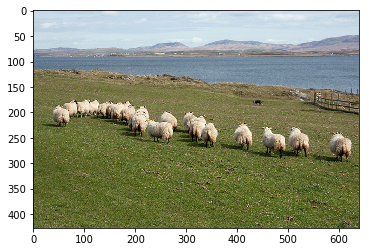

In [7]:
# Load and visualize a random image
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
plt.imshow(image)
plt.show()

Processing 1 images
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
CPU times: user 2.6 s, sys: 488 ms, total: 3.09 s
Wall time: 4.04 s


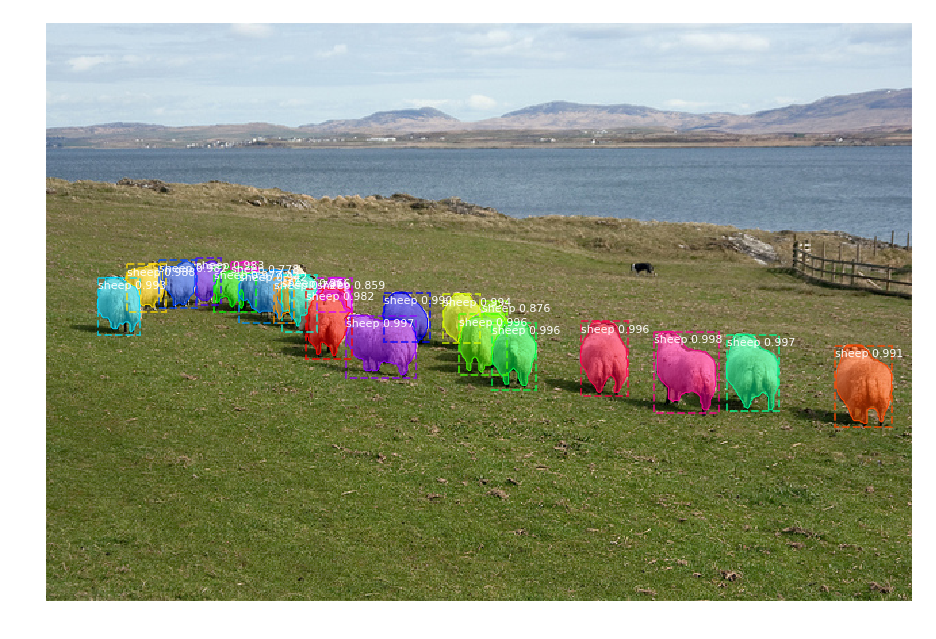

In [8]:
# Test the pre-trained model
# I now call the `detect` function of the model on the list of images we want to be segmented. 
#This returns a `result` object; inspect this object to see what it contains.

The `visualize` helper module provides useful functions to visualize our segmentation results. Understand how this function works (SHIFT+TAB in Jupyter is useful, as well as looking at the code in `visualize.py` directly).
%%time
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [9]:
## Training from scratch. Load the data

Load the annotations for the training images into memory.%%time
config = coco.CocoConfig()
COCO_DIR = "2014"
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "minival")
dataset.prepare()

loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
CPU times: user 484 ms, sys: 52 ms, total: 536 ms
Wall time: 615 ms


In [10]:
# Load the same for the test images.

%%time
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val35k")
dataset_val.prepare()

loading annotations into memory...
Done (t=4.75s)
creating index...
index created!
CPU times: user 5.61 s, sys: 272 ms, total: 5.88 s
Wall time: 6.31 s


In [11]:
# List a few object classes

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    if i > 10:
        break

Image Count: 4952
Class Count: 81
  0. BG                                                
  1. person                                            
  2. bicycle                                           
  3. car                                               
  4. motorcycle                                        
  5. airplane                                          
  6. bus                                               
  7. train                                             
  8. truck                                             
  9. boat                                              
 10. traffic light                                     
 11. fire hydrant                                      


image_id  304 http://cocodataset.org/#explore?id=311789
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000
mask                     shape: (427, 640, 2)         min:    0.00000  max:    1.00000
class_ids                shape: (2,)                  min:   16.00000  max:   67.00000
bbox                     shape: (2, 4)                min:    0.00000  max:  640.00000


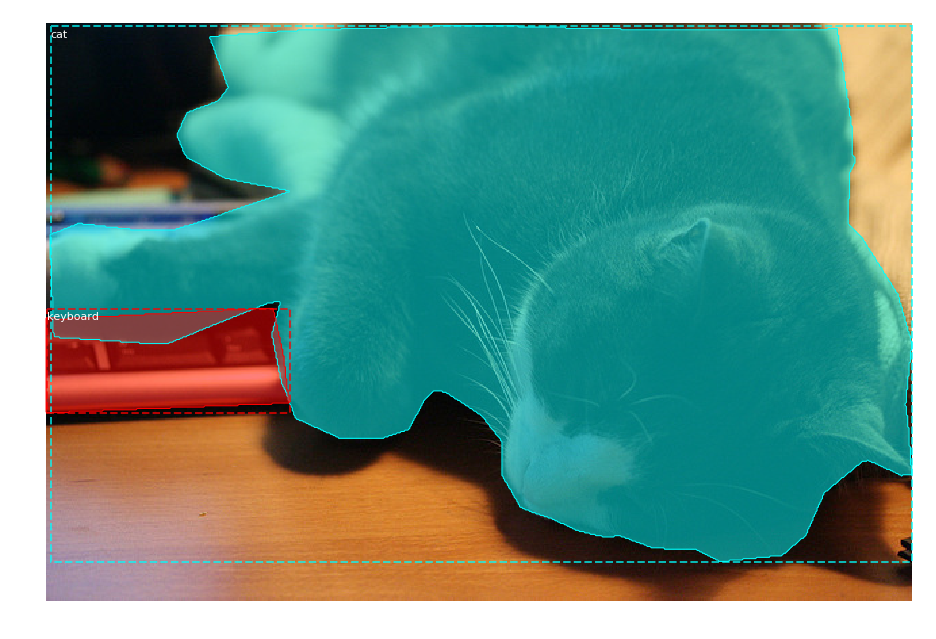

In [12]:
# Visualize a random image and its annotations
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [13]:
# Training configuration

class TrainConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 60

config = TrainConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

In [14]:
# Create a new model in training mode
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

In [15]:
# Initialize the model weights with the weights learned on COCO [5 points]
# Call `load_weights` as before, but add the following argument in the call to the function:

#```
# exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#          "mrcnn_bbox", "mrcnn_mask"]
#```

model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
          "mrcnn_bbox", "mrcnn_mask"])

In [16]:
# Train the model for 10 epochs
%%time
# call to train
model.train(dataset, dataset_val, learning_rate=config.LEARNING_RATE, epochs=10, layers="heads")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)



Starting at epoch 0. LR=0.002

Checkpoint Path: /home/ubuntu/logs/coco20171205T0428/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
60/60 [==============================] - 68s 1s/step - loss: 3.6260 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.3273 - mrcnn_class_loss: 1.5823 - mrcnn_bbox_loss: 0.8037 - mrcnn_mask_loss: 0.8910 - val_loss: 2.8294 - val_rpn_class_loss: 0.0650 - val_rpn_bbox_loss: 1.2785 - val_mrcnn_class_loss: 0.5527 - val_mrcnn_bbox_loss: 0.4669 - val_mrcnn_mask_loss: 0.4663
Epoch 2/10
60/60 [==============================] - 58s 972ms/step - loss: 2.6079 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.4770 - mrcnn_class_loss: 0.8542 - mrcnn_bbox_loss: 0.6379 - mrcnn_mask_loss: 0.6179 - val_loss: 2.5252 - val_rpn_class_loss: 0.0559 - val_rpn_bbox_loss: 1.3178 - val_mrcnn_class_loss: 0.4560 - val_mrcnn_bbox_loss: 0.3177 - val_mrcnn_mask_loss: 0.3778
Epoch 3/10
60/60 [==============================] - 59s 980ms/step - loss: 2.1536 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.4094 - mrcnn_class_loss: 0.6181 - mrcnn_bbox_loss: 0.5449 - mrcnn_mask_loss: 0.5579 - val_loss: 2.6980 - val_rpn_class_loss

In [17]:
# Load the model in inference (testing) mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [18]:
# Load the last trained model weights.
model_path = model.find_last()[1] # use the last trained weights
model.load_weights(model_path, by_name=True)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (89,)                 min:    0.00000  max: 2068.00000
gt_class_id              shape: (24, 4)               min:    1.00000  max: 1024.00000
gt_bbox                  shape: (24, 4)               min:    1.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 24)      min:    0.00000  max:    1.00000


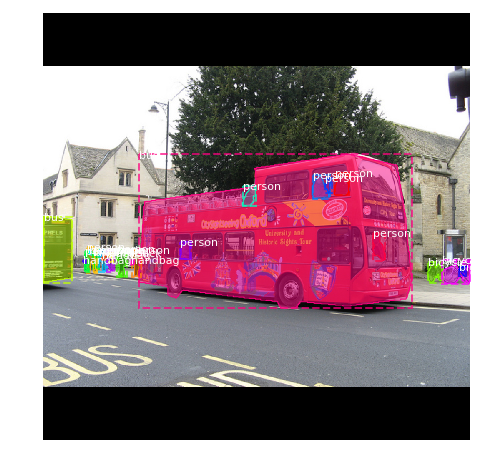

In [29]:
# Visualize the true annotations of a random test image.
inference_config = InferenceConfig()
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


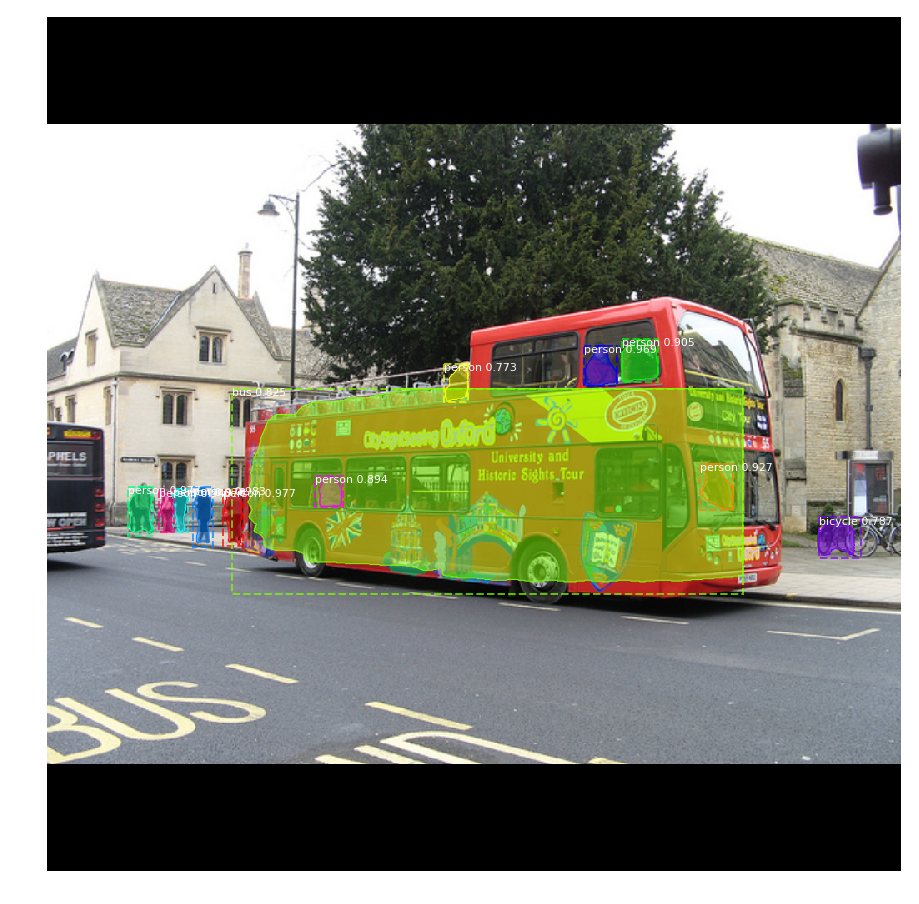

In [30]:
# Visualize the predicted annotations for this image
# prediction function call and visualization
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'])